In [1]:
!pip install mesa --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mesa import Agent, Model
from mesa.agent import AgentSet
from mesa.space import MultiGrid

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


Grid

In [3]:
class OperatingRegion(MultiGrid):
    def __init__(self, width, height, n_pois):
        super().__init__(width, height, torus=False)
        self.width = width
        self.height = height
        self.pois = self._generate_pois(n_pois)

    def _generate_pois(self, n_pois):
        pois = []
        for _ in range(n_pois):
            x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
            pois.append((x, y))
        return pois

    def is_within_bounds(self, pos):
        x, y = pos
        return 0 <= x < self.width and 0 <= y < self.height


In [4]:
region = OperatingRegion(width=100, height=100, n_pois=10)
print("POIs:", region.pois)
#test grid

POIs: [(34, 84), (90, 1), (50, 39), (59, 38), (8, 8), (26, 31), (52, 83), (65, 45), (8, 39), (63, 56)]


Driver

In [5]:
from mesa import Agent

class Vehicle:
    def __init__(self, vehicle_id, speed=1, capacity=1):
        self.vehicle_id = vehicle_id
        self.speed = speed
        self.capacity = capacity

class Driver(Agent):
    def __init__(self, unique_id, model, vehicle, search_strategy="random", insight_prob=0.5):
        # super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.model = model
        self.pos = None
        self.state = "active"  # or "inactive"
        self.vehicle = vehicle
        self.search_strategy = search_strategy
        self.insight_prob = insight_prob
        self.waiting_time = 0
        self.working_time = 0

    def step(self):
        self.working_time += 1
        self.waiting_time += 1

        if self.search_strategy == "random":
            self.random_move()
        elif self.search_strategy == "poi":
            self.move_to_poi()
        elif self.search_strategy == "ride_start":
            pass  # Will be defined when trips are integrated

    def random_move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        valid_steps = [step for step in possible_steps if self.model.grid.is_cell_empty(step) and self.model.grid.is_within_bounds(step)]
        if valid_steps:
            new_pos = self.random.choice(valid_steps)
            self.model.grid.move_agent(self, new_pos)

    def move_to_poi(self):
        if not self.model.grid.pois:
            return
        poi = self.random.choice(self.model.grid.pois)
        x, y = self.pos
        px, py = poi
        dx = 1 if px > x else (-1 if px < x else 0)
        dy = 1 if py > y else (-1 if py < y else 0)
        new_pos = (x + dx, y + dy)
        if self.model.grid.is_within_bounds(new_pos):
            self.model.grid.move_agent(self, new_pos)


Rider class

In [6]:
from mesa import Agent
from mesa.space import MultiGrid

class DiscreteGrid(MultiGrid):
    def move_agent(self, agent, pos):
        if self.is_within_bounds(pos):
            self.remove_agent(agent)
            self.place_agent(agent, pos)

class Rider(Agent):
    def __init__(self, unique_id, model):
        # super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.model = model
        self.pos = None
        self.wait_time = 0

    def step(self):
        self.wait_time += 1


Model

In [7]:
from mesa import Model
import numpy as np
from mesa.time import RandomActivation

class RideShareModel(Model):
    def __init__(self, width=100, height=100, n_drivers=None, n_riders=None, n_pois=10):
        super().__init__()
        self.n_drivers = n_drivers or np.random.randint(3, 10)
        self.n_riders = n_riders or np.random.randint(5, 20)

        self.grid = OperatingRegion(width, height, n_pois)
        self.schedule = RandomActivation(self)

        # Create drivers
        for i in range(self.n_drivers):
            vehicle = Vehicle(i)
            driver = Driver(i, self, vehicle)
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            self.grid.place_agent(driver, (x, y))
            self.schedule.add(driver)

        # Create riders
        for i in range(self.n_riders):
            rider = Rider(self.n_drivers + i, self)
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            self.grid.place_agent(rider, (x, y))
            self.schedule.add(rider)

    def step(self):
        self.schedule.step()


visualization

In [8]:
import matplotlib.pyplot as plt

def plot_grid(model):
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    ax.set_xlim(0, model.grid.width)
    ax.set_ylim(0, model.grid.height)

    # Plot POIs
    for (x, y) in model.grid.pois:
        plt.plot(x + 0.5, y + 0.5, "r*", markersize=10, label="POI" if "POI" not in ax.get_legend_handles_labels()[1] else "")

    # Plot agents
    for agent in model.schedule.agents: # Changed from model.agents
        x, y = agent.pos
        if isinstance(agent, Driver):
            plt.plot(x + 0.5, y + 0.5, "bo", label="Driver" if "Driver" not in ax.get_legend_handles_labels()[1] else "")
        elif isinstance(agent, Rider):
            plt.plot(x + 0.5, y + 0.5, "go", label="Rider" if "Rider" not in ax.get_legend_handles_labels()[1] else "")

    plt.grid(True)
    plt.legend()
    plt.title("Simulation Step")
    plt.show()


Simulation

Step 1


/tmp/ipykernel_6461/2735196031.py:12: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


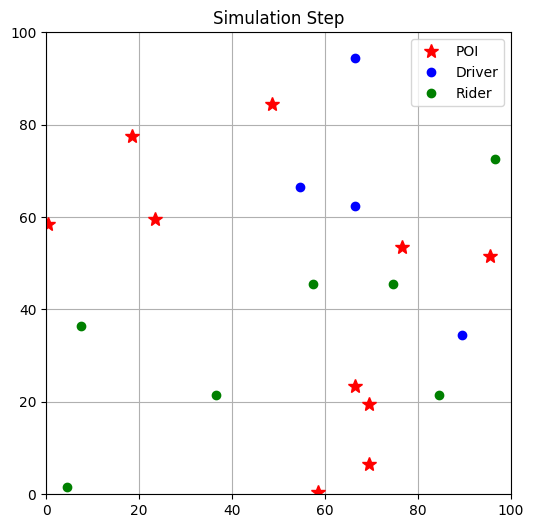

Step 2


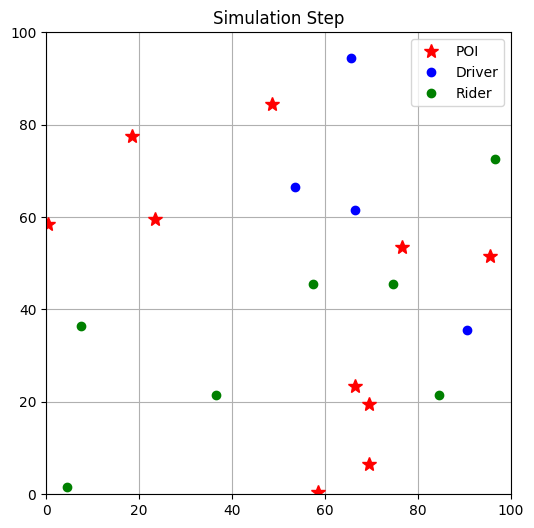

Step 3


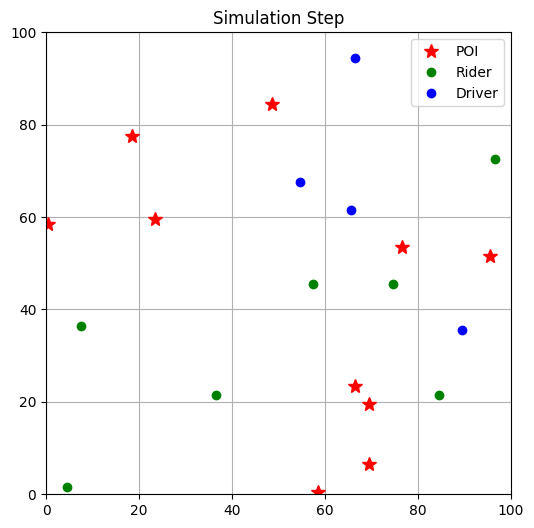

Step 4


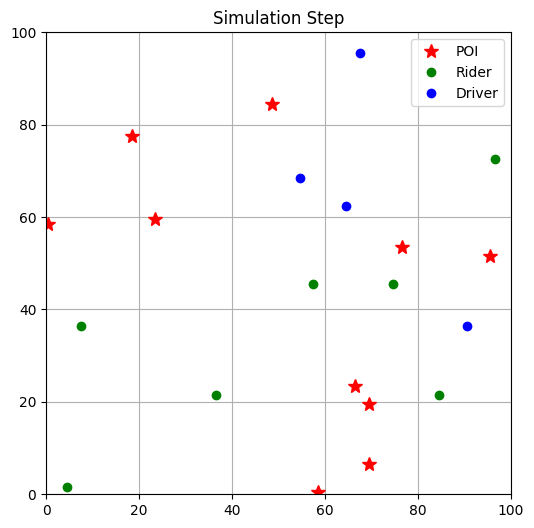

Step 5


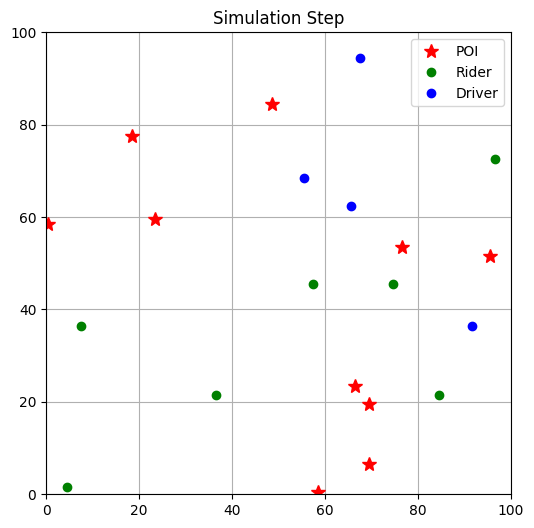

In [9]:
model = RideShareModel()

for i in range(5):
    print(f"Step {i + 1}")
    model.step()
    plot_grid(model)
